In [1]:
import torch

torch.cuda.is_available()

True

In [2]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce MX150'

In [1]:
!wget --content-disposition https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan2/versions/1/files/stylegan2-ffhq-512x512.pkl -O stylegan2-ffhq-512x512.pkl
!wget --content-disposition https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhqu-256x256.pkl -O stylegan3-r-ffhqu-256x256.pkl

--2024-05-20 13:09:09--  https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan2/versions/1/files/stylegan2-ffhq-512x512.pkl
Resolving api.ngc.nvidia.com (api.ngc.nvidia.com)... 52.89.224.217, 54.201.20.7
Connecting to api.ngc.nvidia.com (api.ngc.nvidia.com)|52.89.224.217|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://files.ngc.nvidia.com/org/nvidia/team/research/models/stylegan2/versions/1/files/stylegan2-ffhq-512x512.pkl?versionId%3DPgUqAXxvpc6n4kP.aj5CUKTur7PTLDif&Expires=1716289749&Signature=WrfzfshhCEIOMUS8nY0mTXbmX12d4qEOy1C4y7F8ygFtjUbK2kRI5AiOHAxZi07keK6XqW80y5ISpFv~A0L2D2LPyZX8-V~r6HgG5cr5zHs1iegEln7PAcX22DivNY7kFpP4yCYZYvlmRzXuUaWS3INTrKiV-kgc5-~uxOfJTD1oa2-FAUk6pfHRyGTgT5o-2dZl~pEPb06dyuApN-RGGuZVDVMbsXmzCk~4nGYAdxkegq9W3wd1DJf2ht3UtAQq1M5Qtp-JWv850SFAqHRquU-YIMWkD33O~jYJLPiVMI20dnluPK6dGm7GOIkdFw-z1veO1fl8EZQPhtqjHAJbrg__&Key-Pair-Id=KCX06E8E9L60W [following]
--2024-05-20 13:09:09--  https://files.ngc.nvidia.com/org/nvidia/team

In [2]:
!export CUDA_HOME=$CONDA_PREFIX

In [2]:
import torch
import pickle
import torch

with open('./stylegan3-r-ffhqu-256x256.pkl', 'rb') as f:
    G = pickle.load(f)['G_ema'].cuda()  # torch.nn.Module
z = torch.randn([1, G.z_dim]).cuda()    # latent codes
c = None                                # class labels (not used in this example)
img = G(z, c)                           # NCHW, float32, dynamic range [-1, +1], no truncation

/home/ignatella/anaconda3/envs/stylegan3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


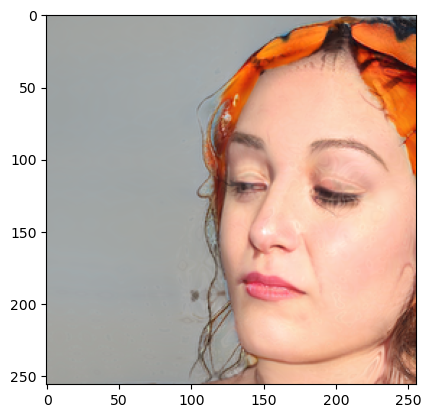

In [3]:
# show image

import matplotlib.pyplot as plt

plt.imshow((img.squeeze().permute(1, 2, 0).cpu().detach().numpy() + 1) / 2)

In [4]:
import os
os.makedirs("./generated-faces/", exist_ok=True)

In [1]:
import numpy as np
import PIL.Image
import torch

def seed2vec(G, seed):
  return np.random.RandomState(seed).randn(1, G.z_dim)

def get_label(G, device, class_idx):
  label = torch.zeros([1, G.c_dim], device=device)
  if G.c_dim != 0:
      if class_idx is None:
          ctx.fail("Must specify class label with --class when using "\
            "a conditional network")
      label[:, class_idx] = 1
  else:
      if class_idx is not None:
          print ("warn: --class=lbl ignored when running on "\
            "an unconditional network")
  return label

def generate_image(device, G, z, truncation_psi=1.0, noise_mode='const',
                   class_idx=None):
  z = torch.from_numpy(z).to(device)
  label = get_label(G, device, class_idx)
  img = G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
  img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(\
      torch.uint8)
  return PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB')

In [14]:
import dnnlib
import pickle
import torch
import dnnlib

# Better for faces
# SEEDS = [6624,6618,6616]
SEEDS = [34, 36, 38, 40]
STEPS = 50
URL = "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan2/versions/1/files/stylegan2-ffhq-512x512.pkl"

# Remove any prior results
!rm ./generated-faces/*

with dnnlib.util.open_url(URL) as f:
    G = pickle.load(f)['G_ema'].cuda()

# Generate the images
idx = 0
for i in range(len(SEEDS)-1):
  v1 = seed2vec(G, SEEDS[i])
  v2 = seed2vec(G, SEEDS[i+1])

  diff = v2 - v1
  step = diff / STEPS
  current = v1.copy()

  for j in range(STEPS):
    current = current + step
    img = generate_image(torch.device('cuda'), G, current)
    img.save(f'./generated-faces/frame-{idx}.png')
    idx+=1

In [19]:

import os


for i in range(1, 10):
    for j in range(1, 4):
        file_name = f'person{i}-{j}.png'
        new_file_name = f'person0{i}-{j}.png'

        os.rename(f'./faces/{file_name}', f'./faces/{new_file_name}')
# create a video from the images

